# Tutorial 6 : Neural Process Images

Last Update : 25 July 2019

**Aim**: 


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

SVHN 
MNIST
CELEBA


In [32]:
import ntbks_add_data as adddata 
from utils.data.ssldata import get_dataset, get_train_dev_test_ssl

In [5]:
c=adddata.get_dataset("celeba")

In [34]:
celeba = adddata.get_dataset("celeba")()
svhn = get_dataset("svhn")()
mnist_train, _, mnist_test = get_train_dev_test_ssl("mnist", dev_size=0)

Using downloaded and verified file: /master/utils/data/../../data/SVHN/train_32x32.mat


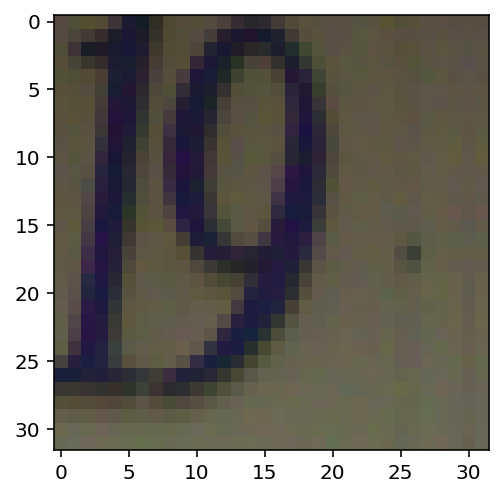

In [35]:
# SVHN
im_idx = 1
plt.imshow(svhn[im_idx][0].permute(1, 2, 0)) 

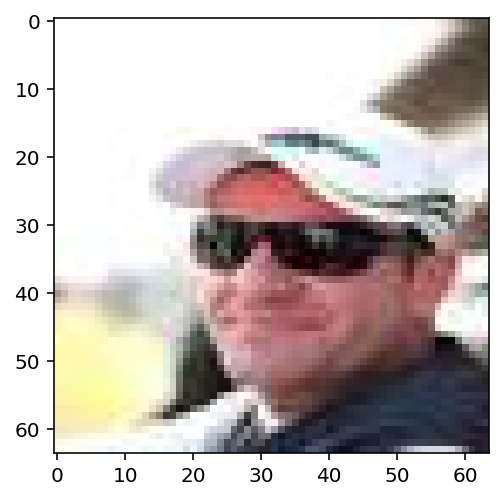

In [36]:
# CELEBA
plt.imshow(celeba[im_idx][0].permute(1, 2, 0)) 

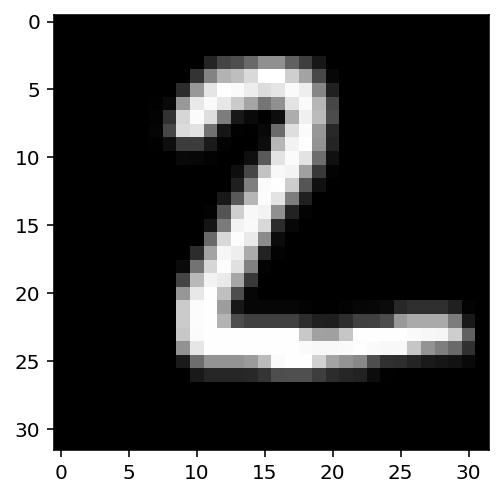

In [37]:
# MNIST
im_idx = 1
# SAMPLED IMAGE
plt.imshow(mnist_test[im_idx][0].squeeze(0), cmap='gray') 

In [39]:
from skssl.transformers.neuralproc.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.1, max_nnz=0.5),
                                     target_masker=no_masker,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt_feat = GridCntxtTrgtGetter(context_masker=get_all_indcs,
                                     target_masker=no_masker,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.1, max_nnz=0.5),
                                 target_masker=RandomMasker(min_nnz=0.5, max_nnz=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(batch):
        min_length = min([v.size(0) for b in batch for k,v in b[0].items() if "X" in k])
        # chose first min_legth of each (assumes that randomized)
        
        batch = [({k:v[:min_length, ...] for k,v in b[0].items()}, b[1]) for b in batch]        
        collated = torch.utils.data.dataloader.default_collate(batch)
        
        X = collated[0]["X"]
        y = collated[0]["y"]
        
        if is_repeat_batch:
            
            X = torch.cat([X,X], dim=0)
            y = torch.cat([y,y], dim=0)
            collated[1] = torch.cat([collated[1], collated[1]], dim=0) # targets
        
        collated[0]["X"], collated[0]["y"], collated[0]["X_trgt"], collated[0]["y_trgt"] = get_cntxt_trgt(X, y)
        
        return collated
    return mycollate

In [40]:
data = mnist
datasets = dict(mnist=mnist)

In [41]:
X_DIM = 2  # 2D spatial input 
Y_DIM = data.shape[0]
N_TARGETS = data.n_classes

sampling_percentages = [1]
label_percentages = [N_TARGETS, N_TARGETS*2, 0.01, 0.05, 0.1, 0.3, 0.5, 1]

# Model

In [42]:
from skssl.transformers import GlobalNeuralProcess, AttentiveNeuralProcess
from skssl.predefined import UnetCNN, CNN, SelfAttention, MLP


anp_kwargs = dict(r_dim=128, 
                  get_cntxt_trgt=get_cntxt_trgt,
                  attention="transformer",
                  encoded_path="deterministic")


# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **anp_kwargs), data) 
                   for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:65: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


In [43]:
from utils.helpers import count_parameters

In [44]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 181346


# Training

In [ ]:
from ntbks_helpers import train_all_models_

train_all_models_(data_models, "results/notebooks/neural_process/u_gnp_layer14",
                  is_retrain=True) # if false load precomputed